# Project Report - Model

In [4]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from torch.utils.data import DataLoader

from tqdne.wgan_model import WDiscriminator, WGenerator
from tqdne.gan import WGAN
from tqdne.metric import PowerSpectralDensity, RepresentationInversion, SamplePlot
from tqdne.representations import CenteredMaxEnvelope
from tqdne.utils import load_model, get_last_checkpoint
from tqdne.dataset import WaveformDataset
from tqdne.conf import Config
from tqdne.training import get_pl_trainer

config = Config()

## Introduction

**Generative Adversarial Networks (GANs)**[@goodfellow2014generative] have emerged as a revolutionary technique in the field of deep learning, offering a powerful framework for generating high-quality data samples from complex distributions. Introduced by Ian Goodfellow and his colleagues in 2014, GANs consist of two neural networks, namely the generator and the discriminator, engaged in a minimax game. The generator aims to produce synthetic data samples that are indistinguishable from genuine data, while the discriminator attempts to differentiate between real and fake samples. Through adversarial training, GANs learn to generate highly realistic data across various domains.

In practice, however, **GANs** have proven to be particularly tricky to converge, facing many problems as numerical instability, mode collapse and vanishing gradients. This is partially attributed to the *competition* between generator and discriminator, as roughly speaking, the generator can only get as good as the discriminator, while if the latter gets too good, the generator has no chance of improving.

With this in mind, **Wasserstein GAN (WGAN)**[@arjovsky2017wasserstein] represents a notable advancement in the GAN architecture. It changes the design by substituting 
traditional Kullback-Leibler divergence for training loss to the Wasserstein distance as the metric for measuring the discrepancy between the distributions of real and generated data. Optimizing the Wasserstein distance still allows for a clean formulation of the loss, while improving on the flaws listed above.

In this project report, we delve into the application of Generative Adversarial Networks, particularly Wasserstein GANs, in the context of earthquake seismic wave simulation. By harnessing the capabilities of GANs and WGANs, we aim to develop models capable of generating synthetic seismic waveforms conditioned on the magnitude of the earthquake and distance to the epicenter of the measurement of the wave with high statistical resemblence to real-world observations.

## Model Design

### Generator and Discriminator

We start by initializing the Generator and Discriminator of our GAN as below. We use four convolutional layers for both, with the Generator having an embedding layer for its latent space before the convolutional layers and the Discriminator having a fully connected layer after the convolutions to obtain its score.

For the Generator each convolution is followed by ReLU and a Batch Normalization layer.

For the Discriminator each convolution is followed by LeakyReLU.

The models are implemented in the `tqdne.wgan_model` module.

In [5]:
G = WGenerator(
    latent_dim=128,
    wave_size=1024,
)
print(G)


WGenerator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=144, out_features=16384, bias=True)
    (1): ReLU()
  )
  (features_to_signal): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (4): ReLU()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (7): ReLU()
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose1d(32, 1, kernel_size=(4,), stride=(2,), padding=(1,))
  )
)


In [6]:
D = WDiscriminator(
    wave_size=1024,
)
print(D)

WDiscriminator(
  (image_to_features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.2)
  )
  (features_to_prob): Sequential(
    (0): Linear(in_features=16400, out_features=1, bias=True)
  )
)


### Embedding of Conditions:

To account for the fact that we want to generate seismic data under certain conditions, namely the distance from the hypocenter and the magnitude, we have to add conditional information to our model. 

In particular, every waveform has a single scalar as `dist` and one as `mag`. We use positional encoding to add this information both to the Generator and Discriminator, although in slightly different ways.

- *Generator:* We concatenate the positional embedding of the conditions with the latent space input of the Generator. This means the embedding goes through the fully connected and convolutional layers alongside the random sample from the latent space.

- *Discriminator:* We concatenate the positional embedding of the conditions to the output of the block of convolutional layers. This means the conditions are only considered at the final fully connected layer of the discriminator.

Both Generator and Discriminator accept a hyperparameter `encoding_L` to be the length used by the positional encoding.

For a complete set of hyperparameters, here it follows:

In [7]:
generator_parameters = {
    "latent_dim": 128, #Dimension of the latent space
    "wave_size": 1024,
    "out_channels": 2, #Depends on the representation chosen
    "encoding_L": 8, #Length of positional encoding
    "num_cond_vars": 2, #Mag and Dist
    "dim": 32, #Controls the number of filters of the convolution layers
}
discriminator_parameters = {
    "wave_size": 1024,
    "in_channels": 2, #Depends on the representation chosen
    "encoding_L": 8, #Length of positional encoding
    "num_cond_vars": 2, #Mag and Dist
    "dim": 32, #Controls the number of filters of the convolution layers
}

### WGAN

The Wasserstein GAN implemented in `tqdne.gan` is a PyTorch Lightning Module that initializates both Generator and Discriminator and coordinates the training. It takes care of the training, sampling, and all the interactions with the model. We use the Adam optimizer throughout the experiments.

It notably has a common modification to GAN training by running one step of the Generator for each `n_critics` steps for the Discriminator, where `n_critics` is a hyperparameter. Moreover, we also have a hyperparameter `reg_lambda` that controls the multiplicative constant of the gradient penalty of the WGAN loss.

For a full set of hyperparameters, refer below:

In [8]:
optimizer_parameters = { #Adam optimizer parameters
    "lr": 1e-4,
    "b1": 0.9,
    "b2": 0.99,
}
model_parameters = {
    "reg_lambda": 10.0, #Gradient penalty coefficient
    "n_critics": 3, #Number of critic iterations per generator iteration
    "optimizer_params": optimizer_parameters,
    "generator_params": generator_parameters,
    "discriminator_params": discriminator_parameters,
    "conditional": True, # Flag to use conditional WGAN
}

In [9]:
model = WGAN(**model_parameters)

2024-02-15 15:35:45 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmpss9mnnsr
2024-02-15 15:35:45 - torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmpss9mnnsr/_remote_module_non_scriptable.py


## Runs & Metrics

Due to the limited performance of the approach so far, we limited the metrics of performance to visual inspection and negative critic loss, the latter being considered as a good indicator of convergence of a GAN. The metrics are automatically tracked on Weights & Biases.

Metrics inherit from a standard interface `AbstractMetric` and allow for simple modularity. Each metric implements a update, compute and plot method, to obtain new data, compute the metric, and possibly plot it, respectively.

More importantly, we heavily use a wrapper metric `RepresentationInversion` that is responsible for inverting the `Representation` transformation used for the dataset before computing or plotting the desired metric.

Below follows an example of how to add metrics tracking to the training process:

In [ ]:
representation = CenteredMaxEnvelope(config)
metrics = [PowerSpectralDensity(config.fs, channel=0), SamplePlot(config.fs, channel=0)]
metrics = [RepresentationInversion(m, representation) for m in metrics]

Now we also include the dataset, as it will be necessary for what comes next.

In [ ]:
train_path = config.datasetdir / Path(config.data_upsample_train)
test_path = config.datasetdir / Path(config.data_upsample_test)
dataset_train = WaveformDataset(train_path, representation, reduced=1024)
dataset_test = WaveformDataset(test_path, representation, reduced=1024)

Now it only remains to load the Pytorch Lighning trainer and start it. Indeed, we have a helper function `get_pl_trainer` which configures and retuns our trainer but also attaches the logic for the handling of metrics to the trainer.
It goes as following:

In [ ]:
trainer_parameters = {
    "max_epochs": 100,
    "accelerator": "auto",
    "devices": "auto",
    "log_every_n_steps": 10,
}
trainer = get_pl_trainer(
    name="Interactive WGAN",
    val_loader=DataLoader(dataset_test, batch_size=64),
    metrics=metrics,
    eval_every=10,
    log_to_wandb=True,
    config=config,
    **trainer_parameters,
)

/users/fmachado/.cache/pypoetry/virtualenvs/tqdne-h7mN2Kd5-py3.11/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/fmachado/.cache/pypoetry/virtualenvs/tqdne-h7 ...
2024-02-12 23:07:38 - pytorch_lightning.utilities.rank_zero - INFO - GPU available: False, used: False
2024-02-12 23:07:38 - pytorch_lightning.utilities.rank_zero - INFO - TPU available: False, using: 0 TPU cores
2024-02-12 23:07:38 - pytorch_lightning.utilities.rank_zero - INFO - IPU available: False, using: 0 IPUs
2024-02-12 23:07:38 - pytorch_lightning.utilities.rank_zero - INFO - HPU available: False, using: 0 HPUs


Now it remains to start training with the fit function, with the option of resuming the training that is automatically stored at the configured output directory.

In [ ]:
resume = False

if resume:
    last_checkpoint = get_last_checkpoint(config.outputdir / "Interactive WGAN")
else:
    last_checkpoint = None

# trainer.fit(
#     model,
#     train_dataloaders=DataLoader(dataset_train, batch_size=64),
#     test_dataloaders=DataLoader(dataset_test, batch_size=64),
#     ckpt_path=last_checkpoint,
# )

Optionally, we can just load the last checkpoint as done below:

In [ ]:
checkpoint = get_last_checkpoint(config.outputdir / "WGAN")
model = WGAN.load_from_checkpoint(checkpoint)

2024-02-12 23:07:38 - root - INFO - Last checkpoint is : /users/fmachado/tqdne/outputs/WGAN/name=0_epoch=47-val_loss=-24.74.ckpt


## Results

As briefly mentioned above, the experiments we conducted failed to converge to ideal solutions. We make this conclusion based on visual inspection of the generated waveforms and the training and validation losses, especially the negative critic part of the loss which is define as $$\mathbb{E}_{x \sim p_{real}}[D(x)] -  \mathbb{E}_{z \sim p_{latent}}[D(G(z)]$$
and is generaly atributed as a strong indicator of convergence (or the opposite).

Here we can see that an experiment with the exact hyperparameters described above has its validation loss increase with the number of steps, a clear sign of divergence.

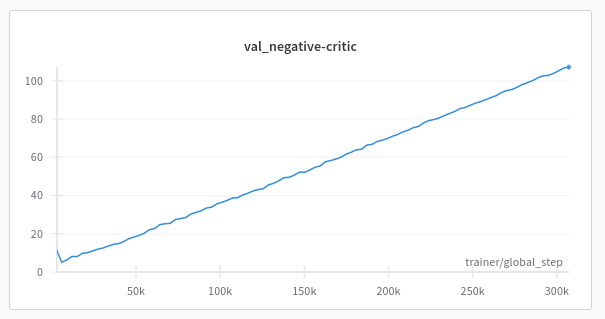

and here we can check two samples, conditioned with the same magnitude and distance, with the green been the synthetic waveform and the red the target. 

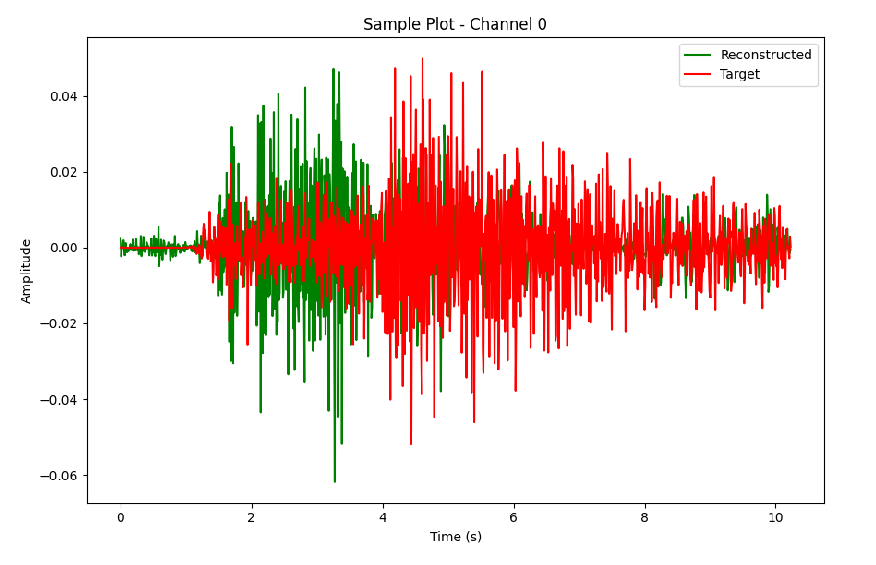

Although we do not expect the waves to look exactly the same, some key properties like the beginning of the wave containing relatively very small amplitudes are key part of seismic waveforms and are not present on the synthetic ones. Moreover, seismic waveforms consistely have a first increase in amplitude at about $1s$ on the plot above, called a P-wave, and a second increase in amplitude that can be noticed at around time $4s$ on the plot above, called the S-wave. These mismatchings are consistently observed throughout the samples logged at Weights & Biases.

Other metrics can be used to assert the convergence, but in this case these are enough to conclude.